Presentation:<https://docs.google.com/presentation/d/1LEzW1ufEjACGxjvvCJHI9O3r1M0W3Q9qh-prBqR_V8U/edit?usp=sharing>
<a id="6"><a/>

# Title:
# Market research

## Project description:
You’ve decided to open a small robot-run cafe in Los Angeles. The project is promising but expensive, so you and your partners decide to try to attract investors. They’re interested in the current market conditions—will you be able to maintain your success when the novelty of robot waiters wears off?
Your partners have asked you to prepare some market research. You have open-source data on restaurants in LA.

#### Navigation through the course of the study:
1. [Load libraries](#1)
2. [Opening data](#2)
3. [Preprocessing the data](#3)
4. [Data Analysis](#4)
>* 4.1 [Investigate the proportions of the various types of establishments?](#4.1)
>* 4.2 [Investigate the proportions of chain and nonchain establishments?](#4.2)
>* 4.3 [Which type of establishment is typically a chain?](#4.3)
>* 4.4 [Determine the average number of seats for each type of establishment. On average, which type of establishment has the greatest number of seats?](#4.4)
>* 4.5 [Put the data on street names from the address column in a separate column](#4.5)
>* 4.6 [Plot a graph of the top ten streets by number of restaurants.](#4.6)
>* 4.7 [Find the number of streets that only have one restaurant.](#4.7)
>* 4.8 [For streets with a lot of restaurants, look at the distribution of the number of seats. What trends can you see?](#4.8)
5. [Conclusions & recommendations](#5)
6. [Presentation slides](#6)

### Load and take a first look at the data.
<a id="1"></a>

In [1]:
!pip install usaddress
import pandas as pd
import usaddress
import re
from pandas.io.json import json_normalize
import json
import plotly.express as px
import seaborn as sns
sns.set(style="darkgrid")
from numpy import median
import matplotlib.pyplot as plt

### Opening data
<a id="2"></a>

In [2]:
try:
    df=pd.read_csv('/datasets/rest_data_us.csv',dtype={'object_name':'category','address':'category',\
                                         'chain':'category','object_type':'category','id':'int32','number':'int32'}) 
except:
    df=pd.read_csv('rest_data_us.csv',dtype={'object_name':'category','address':'category',\
                                         'chain':'category','object_type':'category','id':'int32','number':'int32'}) 

In [3]:
df.head()

id          object_name                    address  chain object_type  \
0  11786  HABITAT COFFEE SHOP     3708 N EAGLE ROCK BLVD  FALSE        Cafe   
1  11787             REILLY'S        100 WORLD WAY # 120  FALSE  Restaurant   
2  11788       STREET CHURROS  6801 HOLLYWOOD BLVD # 253  FALSE   Fast Food   
3  11789    TRINITI ECHO PARK         1814 W SUNSET BLVD  FALSE  Restaurant   
4  11790               POLLEN         2100 ECHO PARK AVE  FALSE  Restaurant   

   number  
0      26  
1       9  
2      20  
3      22  
4      20

In [4]:
df['chain'].unique()

[FALSE, TRUE, NaN]
Categories (2, object): [FALSE, TRUE]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
id             9651 non-null int32
object_name    9651 non-null category
address        9651 non-null category
chain          9648 non-null category
object_type    9651 non-null category
number         9651 non-null int32
dtypes: category(4), int32(2)
memory usage: 906.5 KB


In [6]:
df.describe(include='all')

id                 object_name              address  chain  \
count    9651.000000                        9651                 9651   9648   
unique           NaN                        8672                 8517      2   
top              NaN  THE COFFEE BEAN & TEA LEAF  3607 TROUSDALE PKWY  FALSE   
freq             NaN                          47                   11   5972   
mean    16611.000000                         NaN                  NaN    NaN   
std      2786.148058                         NaN                  NaN    NaN   
min     11786.000000                         NaN                  NaN    NaN   
25%     14198.500000                         NaN                  NaN    NaN   
50%     16611.000000                         NaN                  NaN    NaN   
75%     19023.500000                         NaN                  NaN    NaN   
max     21436.000000                         NaN                  NaN    NaN   

       object_type       number  
count         9651  9651.000000  
unique           6          NaN  
top     Restaurant          NaN  
freq          7255          NaN  
mean           NaN    43.695161  
std            NaN    47.622874  
min            NaN     1.000000  
25%            NaN    14.000000  
50%            NaN    27.000000  
75%            NaN    46.000000  
max            NaN   229.000000

* The top class of establishment is the Restaurant businesses while the most frequent street is Trousdale PKWY.We have to clean the addresses from the numbers and check again after if this street remains the most popular. The most frequent firma of the establishments seems to be the THE COFFEE BEAN & TEA LEAF

### Preprocessing the data
<a id="3"></a>

In [7]:
#check for missing values
df.isnull().sum()

id             0
object_name    0
address        0
chain          3
object_type    0
number         0
dtype: int64

In [8]:
# fill nan of chain column
df['chain']=df['object_name'].apply(lambda x: 'TRUE' if len(df[df['object_name']==x])>1 else 'FALSE'  )

#check the nans
display(df.isnull().sum())

id             0
object_name    0
address        0
chain          0
object_type    0
number         0
dtype: int64

In [9]:
#check for duplicates
display(df.duplicated().sum())

#check for dublicated id
display(df['id'].duplicated().sum())

0

0

### Data Analysis 
<a id="4"></a>

* Parse the address and split the numbers to investigate if a chain has more than one restaurants in the same street 
or check how many restaraunts are in each street

In [10]:
#Create a dictionary with the parsed values of the addresses 
singe_address=usaddress.parse(df['address'][1])

street_dict={}
for i in singe_address:
    if i[1] not in street_dict.keys():       
        street_dict.update({i[1]:i[0]})
    elif i[1]==str:
        street_dict[i[1]]+=' '+i[0]
    else:
        street_dict[i[1]]+=' '+ str(i[0])
    
street_dict
if 'StreetName' in street_dict.keys():
    name=street_dict['StreetName']
else:
    'incorrect address'
name

'WORLD'

In [11]:
#Define a function for parsing the address and get the street name or other 
def get_street(raw_address):
    #Create a dictionary from each address
    raw_list=usaddress.parse(raw_address)
    raw_dict={}
    for i in raw_list:
        if i[1] and i[1] not in raw_dict.keys():       
            raw_dict.update({i[1]:i[0]})
        elif i[1]==str:
            raw_dict[i[1]]+=' '+i[0]
        else:
            raw_dict[i[1]]+=' '+ str(i[0])

    #Get the street name from the dictionary if there is
    if 'StreetName' in raw_dict.keys():
        name=raw_dict['StreetName']
    else:
        name='incorrect address'
    return name

In [12]:
df['street_name']=df['address'].apply(get_street)

In [13]:
df['street_name'].head()

0    EAGLE ROCK
1         WORLD
2     HOLLYWOOD
3        SUNSET
4     ECHO PARK
Name: street_name, dtype: object

In [14]:
df.head()

id          object_name                    address  chain object_type  \
0  11786  HABITAT COFFEE SHOP     3708 N EAGLE ROCK BLVD  FALSE        Cafe   
1  11787             REILLY'S        100 WORLD WAY # 120  FALSE  Restaurant   
2  11788       STREET CHURROS  6801 HOLLYWOOD BLVD # 253  FALSE   Fast Food   
3  11789    TRINITI ECHO PARK         1814 W SUNSET BLVD  FALSE  Restaurant   
4  11790               POLLEN         2100 ECHO PARK AVE  FALSE  Restaurant   

   number street_name  
0      26  EAGLE ROCK  
1       9       WORLD  
2      20   HOLLYWOOD  
3      22      SUNSET  
4      20   ECHO PARK

## Questions
### Investigate the proportions of the various types of establishments. 
<a id="4.1"></a>

In [24]:
print('Percentage distribution of each type:\n', df['object_type'].value_counts(normalize=True))

Percentage distribution of each type:
 Restaurant    0.751736
Fast Food     0.110455
Cafe          0.045073
Pizza         0.033157
Bar           0.030256
Bakery        0.029323
Name: object_type, dtype: float64


In [25]:
bar=pd.DataFrame(df['object_type'].value_counts())
bar['total_number']=bar['object_type']
bar['object_type']=bar.index
bar.reset_index(drop=True)

object_type  total_number
0  Restaurant          7255
1   Fast Food          1066
2        Cafe           435
3       Pizza           320
4         Bar           292
5      Bakery           283

In [26]:
#bar=pd.DataFrame(df['object_type'].value_counts())
fig=px.bar(bar,x='object_type',y='total_number',color='object_type',title='Establishments distribution',\
           labels={'x':'Type of establishment','y':'Total number'})
fig.show()

Restaurants occupied the 75% of the market following the Fast food type of establishment with 11%, cafe with 4,5% and so on.

### Investigate the proportions of chain and nonchain establishments.
<a id="4.2"></a>

In [27]:
df[df['chain']=='TRUE']['object_name'].value_counts()

THE COFFEE BEAN & TEA LEAF           47
SUBWAY                               31
DOMINO'S PIZZA                       15
KENTUCKY FRIED CHICKEN               14
WABA GRILL                           14
MCDONALD'S                           13
TRIMANA                              13
YOGURTLAND                           12
HONG KONG EXPRESS                    12
PAPA JOHN'S PIZZA                    12
STARBUCKS                            12
SUBWAY SANDWICHES                    11
WINGSTOP                             10
LOUISIANA FRIED CHICKEN              10
CHIPOTLE MEXICAN GRILL               10
EL POLLO LOCO                        10
BLUE BOTTLE COFFEE                    9
KFC                                   9
CARL'S JR                             8
BASKIN ROBBINS                        8
JERSEY MIKE'S SUBS                    8
CHINA EXPRESS                         7
PINKBERRY                             7
LA MONARCA BAKERY                     6
WETZEL'S PRETZELS                     6


* Considering that many establishments are recorded as chains but the count of them equals to 1 we assuming that the object name is been stored with a different-similar name that we have to take a look and correct the name entries.
We can observe some of them above like the PAPA JOHN'S  PIZZA,PAO JAO,PAPA JAKE'S SUB SHOP.
* Checking the order from the top with the establishments with the most shops we see the firma SUBWAY and SUBWAY SANDWICHES that after a short research there is no establishment with the name SUBWAY SANDWICHES in Los Angeles.Only SUBWAY.

In [28]:
df['object_name'].replace('SUBWAY SANDWICHES','SUBWAY',inplace=True)
df['object_name'].replace('PAO JAO DUMPLING HOUSE LA ','PAO JAO',inplace=True)
df['object_name'].replace("PAPA JAKE'S SUB SHOP PREP KITCHEN","PAPA JAKE'S",inplace=True)

* We see many corrupted entries also with the BIG MAMAS & PAPAS PIZZERIA and PAPA JAKE'S.

In [29]:
#replace the all the similar names of 'PAPA JOHN' with "PAPA JOHN'S PIZZA"
df.loc[df['object_name'].str.contains('PAPA JOHN'),'object_name']="PAPA JOHN'S PIZZA"
df.loc[df['object_name'].str.contains('BIG MAMA'),'object_name']="BIG MAMA'S"
df.loc[df['object_name'].str.contains("PAPA JAKE'S"),'object_name']="PAPA JAKE'S"

In [30]:
df[df['object_name'].str.contains("PAPA JAKE'S")]

id  object_name               address  chain object_type  number  \
3361  15147  PAPA JAKE'S   6333 W 3RD ST # 510  FALSE  Restaurant      10   
3379  15165  PAPA JAKE'S  6333 W 3RD ST # EK10  FALSE  Restaurant       9   

     street_name  
3361         3RD  
3379         3RD

In [31]:
#Top 20 of the establishments with the most shops
df[df['chain']=='TRUE']['object_name'].value_counts()[:20]

THE COFFEE BEAN & TEA LEAF    47
SUBWAY                        42
DOMINO'S PIZZA                15
WABA GRILL                    14
KENTUCKY FRIED CHICKEN        14
PAPA JOHN'S PIZZA             14
TRIMANA                       13
MCDONALD'S                    13
YOGURTLAND                    12
HONG KONG EXPRESS             12
STARBUCKS                     12
WINGSTOP                      10
CHIPOTLE MEXICAN GRILL        10
EL POLLO LOCO                 10
LOUISIANA FRIED CHICKEN       10
BLUE BOTTLE COFFEE             9
KFC                            9
JERSEY MIKE'S SUBS             8
BASKIN ROBBINS                 8
CARL'S JR                      8
Name: object_name, dtype: int64

We see BIG MAMA'S chain climbed to the 20st rank place, after correcting the names.

In [32]:
#proportions of chain and no-chain establishments
print('The {:.2%} of the market in Los Angeles is formed by chain establishments.'\
      .format(df[df['chain']=='TRUE'].shape[0]/df.shape[0]))

print('The {:.2%} of the market in Los Angeles is formed by no-chain establishments.'\
      .format(df[df['chain']=='FALSE'].shape[0]/df.shape[0]))

The 15.57% of the market in Los Angeles is formed by chain establishments.
The 84.43% of the market in Los Angeles is formed by no-chain establishments.


In [33]:
chain=pd.DataFrame(df['chain'].value_counts())
chain.rename(columns={'chain':'total'},inplace=True)
chain['type_chain']=chain.index
chain=chain.reset_index(drop=True)
chain

total type_chain
0   8148      FALSE
1   1503       TRUE

In [34]:
fig=px.bar(chain,x='type_chain',y='total',color='type_chain',title='Chain & no-chain establishments',\
           labels={'x':'No-chain & chain','y':'count'})
fig.show()

In [35]:
#Top 10 numerous in store chain establishments in % of the total number of establishment in LA
round((df[df['chain']=='TRUE']['object_name'].value_counts()[:10]/df.shape[0])*100,2)

THE COFFEE BEAN & TEA LEAF    0.49
SUBWAY                        0.44
DOMINO'S PIZZA                0.16
WABA GRILL                    0.15
KENTUCKY FRIED CHICKEN        0.15
PAPA JOHN'S PIZZA             0.15
TRIMANA                       0.13
MCDONALD'S                    0.13
YOGURTLAND                    0.12
HONG KONG EXPRESS             0.12
Name: object_name, dtype: float64

### Which type of establishment is typically a chain?
<a id="4.3"><a/>

In [36]:
df[df['chain']=='TRUE']['object_type'].value_counts()

Restaurant    962
Fast Food     266
Cafe          114
Pizza          85
Bakery         49
Bar            27
Name: object_type, dtype: int64

* A chain store or retail chain is a retail outlet in which several locations share a brand, central management, and standardized business practices.
- Here the main 3 types that dominate the market are Restaurant,Fast Food and Cafe

### What characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats?

In [37]:
df.head()

id          object_name                    address  chain object_type  \
0  11786  HABITAT COFFEE SHOP     3708 N EAGLE ROCK BLVD  FALSE        Cafe   
1  11787             REILLY'S        100 WORLD WAY # 120  FALSE  Restaurant   
2  11788       STREET CHURROS  6801 HOLLYWOOD BLVD # 253  FALSE   Fast Food   
3  11789    TRINITI ECHO PARK         1814 W SUNSET BLVD  FALSE  Restaurant   
4  11790               POLLEN         2100 ECHO PARK AVE  FALSE  Restaurant   

   number street_name  
0      26  EAGLE ROCK  
1       9       WORLD  
2      20   HOLLYWOOD  
3      22      SUNSET  
4      20   ECHO PARK

In [38]:
#top 20 in number of chain-stores per Brand
display(df[df['chain']=='TRUE']['object_name'].value_counts()[:20])
top20_name= list(df[df['chain']=='TRUE']['object_name'].value_counts()[:20].index)
display(top20_name)

THE COFFEE BEAN & TEA LEAF    47
SUBWAY                        42
DOMINO'S PIZZA                15
WABA GRILL                    14
KENTUCKY FRIED CHICKEN        14
PAPA JOHN'S PIZZA             14
TRIMANA                       13
MCDONALD'S                    13
YOGURTLAND                    12
HONG KONG EXPRESS             12
STARBUCKS                     12
WINGSTOP                      10
CHIPOTLE MEXICAN GRILL        10
EL POLLO LOCO                 10
LOUISIANA FRIED CHICKEN       10
BLUE BOTTLE COFFEE             9
KFC                            9
JERSEY MIKE'S SUBS             8
BASKIN ROBBINS                 8
CARL'S JR                      8
Name: object_name, dtype: int64

['THE COFFEE BEAN & TEA LEAF',
 'SUBWAY',
 "DOMINO'S PIZZA",
 'WABA GRILL',
 'KENTUCKY FRIED CHICKEN',
 "PAPA JOHN'S PIZZA",
 'TRIMANA',
 "MCDONALD'S",
 'YOGURTLAND',
 'HONG KONG EXPRESS',
 'STARBUCKS',
 'WINGSTOP',
 'CHIPOTLE MEXICAN GRILL',
 'EL POLLO LOCO',
 'LOUISIANA FRIED CHICKEN',
 'BLUE BOTTLE COFFEE',
 'KFC',
 "JERSEY MIKE'S SUBS",
 'BASKIN ROBBINS',
 "CARL'S JR"]

In [39]:
#Top 20 most popular streets with the most chain-stores
df[df['chain']=='TRUE']['street_name'].value_counts()[:20]

WILSHIRE        78
SUNSET          68
WESTERN         63
FIGUEROA        61
VERMONT         46
PICO            44
WORLD           42
OLYMPIC         41
3RD             41
BROADWAY        38
SANTA MONICA    36
HOLLYWOOD       34
6TH             32
BEVERLY         30
SAN VICENTE     25
WESTWOOD        23
WHITTIER        20
CENTRAL         20
VENICE          20
LARCHMONT       18
Name: street_name, dtype: int64

* It would be nice to have here info about the rent price/sq.m to check if there is a relationship between the demand(the number of stores in a street) and the cost of rent

In [40]:
top20_street= list(df[df['chain']=='TRUE']['street_name'].value_counts()[:20].index)
top20_street[:3]

['WILSHIRE', 'SUNSET', 'WESTERN']

In [41]:
#Companies in the 20 most crowded streets with stores, and the number of stores per company in those streets
df[(df['chain']=='TRUE') & (df['street_name'].isin(top20_street))]\
   .groupby('object_name',as_index=False).agg({'street_name':'count','number':'mean'})

object_name  street_name      number
0                   ABC DONUTS            1   21.000000
1                ADMIRALS CLUB            2  161.500000
2               ANGELES BAKERY            2   17.000000
3          ANGELINI ALIMENTARI            1   11.000000
4                ANTIGUA BREAD            1   41.000000
5                    ASIAN BOX            2   25.000000
6                      ATTICUS            2   12.500000
7        AUNTIE ANNE'S PRETZEL            1   15.000000
8               BACKYARD BOWLS            1   33.000000
9                    BAJA BUDS            1   42.000000
10                  BAJA FRESH            3   84.333333
11              BANGKOK PALACE            1   47.000000
12                    BARDONNA            2   12.500000
13            BARNEY'S BEANERY            1   75.000000
14              BASKIN ROBBINS            2   14.000000
15   BASKIN ROBBINS 31 FLAVORS            2   23.000000
16           BERLIN CURRYWURST            2   13.000000
17                 BEST DONUTS            2   13.000000
18                      BIBIGO            2   38.500000
19            BIG JIM'S DONUTS            2   17.000000
20                  BIG MAMA'S            1   28.000000
21               BILLINGSLEY'S            2  194.500000
22                 BLAZE PIZZA            1  113.000000
23                         BLD            3   47.333333
24          BLUE BOTTLE COFFEE            4   27.750000
25                   BOBA BEAR            2   46.500000
26                  BOBA STORY            2    7.500000
27                   BOBA TIME            2   16.500000
28                 BODYFACTORY            2   25.500000
29           BOSCO CAFE BAKERY            2    7.500000
..                         ...          ...         ...
360                  UNO WATER            2   21.000000
361        VALERIE CONFECTIONS            1    8.000000
362           VANESSA'S BAKERY            1   22.000000
363                  VEES CAFE            3   29.666667
364                VEGAN HOUSE            1   39.000000
365                 VERSAILLES            1  144.000000
366            VILLA MORELIANA            1    7.000000
367        VIM THAI RESTAURANT            2   63.000000
368     VIVA TACOS LA ESTRELLA            1    7.000000
369                 WABA GRILL            9   45.333333
370               WAKO DONKASU            2   64.000000
371          WETZEL'S PRETZELS            2   18.500000
372          WETZELS PRETZEL'S            1    4.000000
373           WETZELS PRETZELS            2   18.500000
374              WEXLER'S DELI            2   21.000000
375        WHEALTHY RESTAURANT            2   39.500000
376                 WHICH WICH            1   21.000000
377         WHOLE FOODS MARKET            2   14.500000
378                  WING STOP            1   35.000000
379                   WINGSTOP            7   23.285714
380      WOLFGANG PUCK EXPRESS            2  160.000000
381                   YAMAKASE            2   14.000000
382                YOGURT LAND            2   18.000000
383                 YOGURTLAND            9   16.777778
384                  YOSHINOYA            2   36.500000
385           YOSHINOYA # 4124            2   39.500000
386               YUKO KITCHEN            1   17.000000
387             YUM YUM DONUTS            1   18.000000
388                    Z PIZZA            1   48.000000
389             ZANKOU CHICKEN            2   53.500000

[390 rows x 3 columns]

In [42]:
#Further name corrections and chain-classified to be done here with YOGURT LAND,YOSHINOYA, WETZELS PRETZELS, WINGSTOP
df['object_name'].replace('YOGURT LAND','YOGURTLAND',inplace=True)
df.loc[df['object_name'].str.contains('YOSHINOYA'),'object_name']='YOSHINOYA'
df.loc[df['object_name']=='YOSHINOYA','chain']='TRUE'
df.loc[df['object_name'].str.contains('WETZELS'),'object_name']='WETZELS PRETZELS'
df.loc[df['object_name'].str.contains('WINGSTOP'),'object_name']='WINGSTOP'
df.loc[df['object_name']=='WINGSTOP','chain']='TRUE'

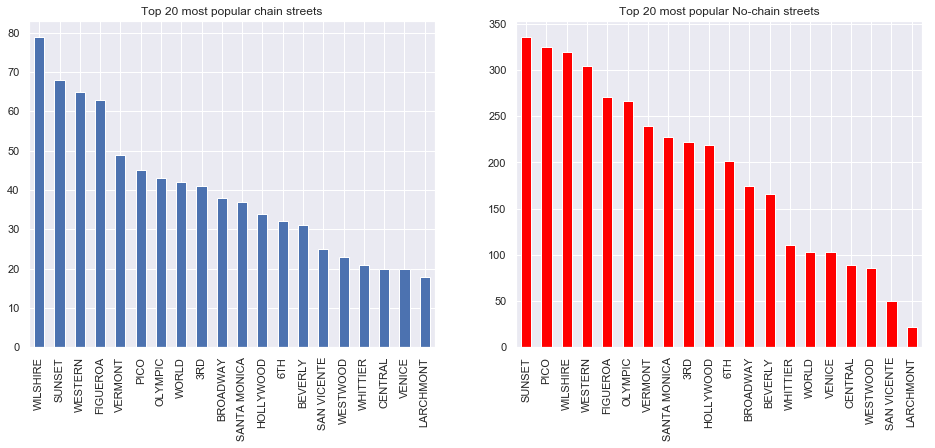

In [43]:
fig,axes=plt.subplots(1,2,figsize=(16,6))
df[(df['chain']=='TRUE') & (df['street_name'].isin(top20_street))]['street_name'].value_counts()\
.plot(kind='bar',ax=axes[0])
axes[0].set_title('Top 20 most popular chain streets')
df[(df['chain']=='FALSE') & (df['street_name'].isin(top20_street))]['street_name'].value_counts()\
.plot(kind='bar',ax=axes[1],color='red')
axes[1].set_title('Top 20 most popular No-chain streets')

plt.show()

* We see small differences in the ranking of the streets between the chain and the no-chain stores.
* Some of them look like to be more interesting for chain-stores like World street which has the 16th rank position for no-chain establishments but for chain-establishments has the 7th position.
* For the Pico street is happening the opposite having the 6th postition in the ranking of popularity for the chain-stores while for the no-chain stores holds the 2nd position.

In [44]:
fig=px.histogram(df,x='number',color='chain',title='Chain vs No-chain seats',labels={'number':'Number of seats'})
fig.show()

* It doesn't look to be any clear difference in the preferable number of seats for the chain and no-chain establishments, besides a small difference in the top spike of each one where for the chains the number of seat is 10-14 while for the no-chain stores is 15-19

In [45]:
#The top 20 chain-brands(with the most stores) in the top 20 streets(streets with the most chain-stores), average 
#number of seats and 
top20_seat_stores=df[(df['chain']=='TRUE') & (df['street_name'].isin(top20_street)) & (df['object_name'].isin(top20_name))]\
   .groupby('object_name',as_index=False).agg({'street_name':'count','number':'mean'})\
   .rename(columns={'object_name':'chain_name','street_name':'number_of_stores','number':'seats'})\
   .sort_values('number_of_stores',ascending=False).reset_index(drop=True)
top20_seat_stores

chain_name  number_of_stores       seats
0   THE COFFEE BEAN & TEA LEAF                33   26.878788
1                       SUBWAY                24   17.458333
2                   YOGURTLAND                11   17.000000
3                     WINGSTOP                10   26.000000
4               DOMINO'S PIZZA                 9   11.111111
5                   WABA GRILL                 9   45.333333
6       CHIPOTLE MEXICAN GRILL                 7   43.571429
7       KENTUCKY FRIED CHICKEN                 7   35.857143
8                          KFC                 6   46.333333
9            PAPA JOHN'S PIZZA                 6   12.500000
10                     TRIMANA                 5   32.400000
11               EL POLLO LOCO                 5   65.000000
12          JERSEY MIKE'S SUBS                 5   25.600000
13                   STARBUCKS                 5   24.000000
14                   CARL'S JR                 4   73.000000
15          BLUE BOTTLE COFFEE                 4   27.750000
16     LOUISIANA FRIED CHICKEN                 3   13.333333
17           HONG KONG EXPRESS                 3   36.666667
18                  MCDONALD'S                 2  100.500000
19              BASKIN ROBBINS                 2   14.000000

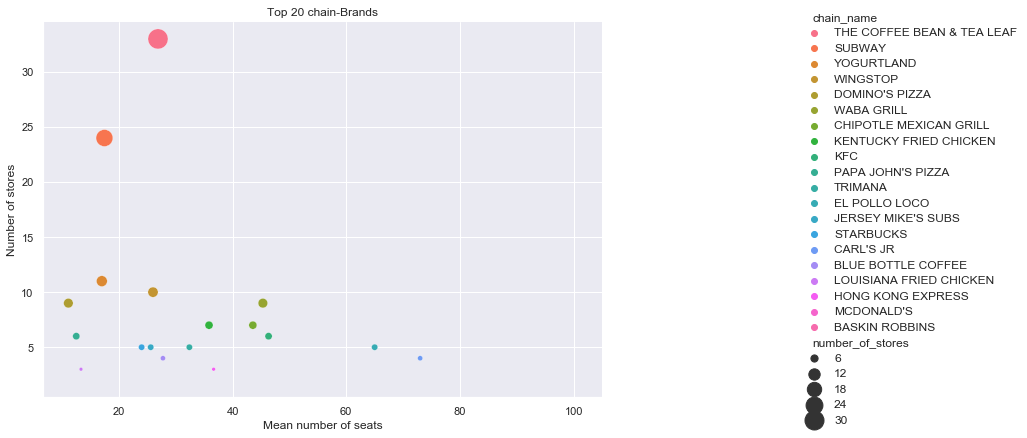

In [46]:
#Plot the number of stores vs mean number of seats of the top 20 chain-Brands in stores
g=sns.relplot(x='seats',y='number_of_stores',hue='chain_name',sizes=(0,400),\
              size='number_of_stores',data=top20_seat_stores)
g.fig.set_size_inches(15,6)
g.set(xlabel='Mean number of seats',ylabel='Number of stores')
plt.title('Top 20 chain-Brands')
#plt.savefig(my_path+'/Top_20_chain-Brands.png',dpi=300,bbox_inches="tight")
plt.show()

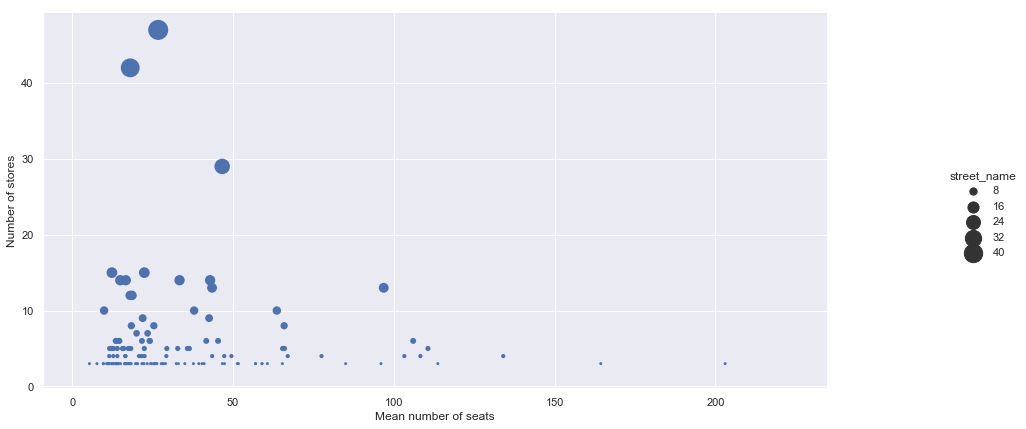

In [47]:
stores_seats=df[df['chain']=='TRUE'].groupby('object_name',as_index=False)\
.agg({'street_name':'count','number':'mean'})

g=sns.relplot(x='number',y='street_name',sizes=(0,400),size='street_name',data=stores_seats)
g.fig.set_size_inches(15,6)
g.set(xlabel='Mean number of seats',ylabel='Number of stores')
plt.show()

* We see that the pattern remains the same for the top-20 in stores Brands, with the overall relationship between the number of the stores and the mean number of seats for each Brand.
* Companies with more stores tend to have mostly less seats while firmas with less stores tend to have bigger number of seats

### Determine the average number of seats for each type of establishment. On average, which type of establishment has the greatest number of seats? 
<a id="4.4"><a/>

In [48]:
seats_per_object=df[df['chain']=='TRUE'].groupby('object_type',as_index=False)['number'].mean()\
.sort_values('number',ascending=False)
seats_per_object

object_type     number
5  Restaurant  40.133333
4       Pizza  30.505882
1         Bar  30.333333
3   Fast Food  30.274436
2        Cafe  25.307018
0      Bakery  20.469388

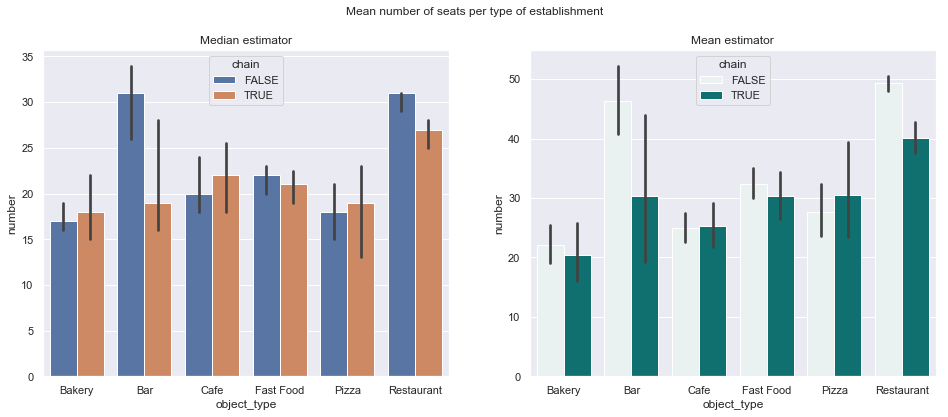

In [49]:
#Mean number of seats per type of establishment
fig,axe=plt.subplots(1,2,figsize=(16,6))
sns.barplot(data=df,x='object_type',y='number',hue='chain',estimator=median,ax=axe[0])
sns.barplot(data=df,x='object_type',y='number',hue='chain',color='teal',ax=axe[1])
axe[0].set_title('Median estimator')
axe[1].set_title('Mean estimator')
fig.suptitle('Mean number of seats per type of establishment')
#plt.savefig(my_path+'/Seats_per_type_of_establishment.png',dpi=300,bbox_inches="tight")
plt.show()

- In overall restaurants have the higher number of seats.
- We see here more clear that bakeries,bars,fast food and restaraunts tend to have higher number of seats when comes for a no-chain establishment while the opposite happens for the chains.
- The opposite happens only for the pizza shops and slightly for the cafes.
- We see that the pattern changes for the bakeries and make more noticable for the cafes if we choose as for estimator the median.That means there were some outliers hense some no-chain cafes have a higher number of seats comparing the rest no-chain cafes.And so the same for the bakeries

### Put the data on street names from the address column in a separate column.
<a id="4.5"><a/>

In [50]:
df.head(2)

id          object_name                 address  chain object_type  \
0  11786  HABITAT COFFEE SHOP  3708 N EAGLE ROCK BLVD  FALSE        Cafe   
1  11787             REILLY'S     100 WORLD WAY # 120  FALSE  Restaurant   

   number street_name  
0      26  EAGLE ROCK  
1       9       WORLD

### Plot a graph of the top ten streets by number of restaurants.
<a id="4.6"><a/>

In [54]:
top10_in_stores.head()

street_name  number_restaurants
0      SUNSET                 404
1    WILSHIRE                 398
2        PICO                 370
3     WESTERN                 369
4    FIGUEROA                 334

street_name  number_restaurants
0        SUNSET                 404
1      WILSHIRE                 398
2          PICO                 370
3       WESTERN                 369
4      FIGUEROA                 334
5       OLYMPIC                 309
6       VERMONT                 288
7  SANTA MONICA                 264
8           3RD                 263
9     HOLLYWOOD                 253

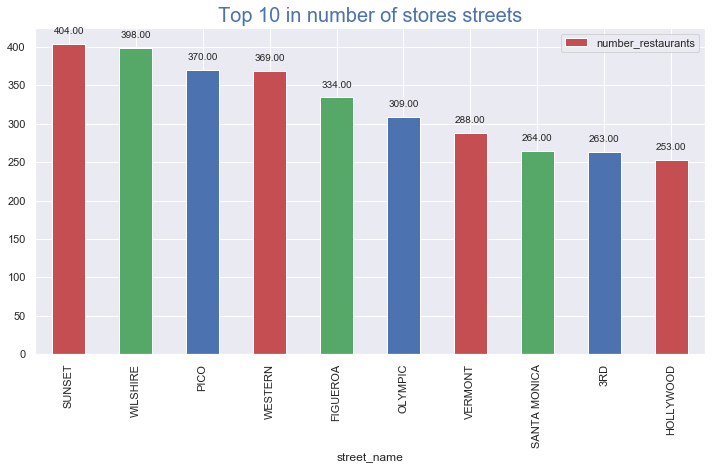

In [73]:
top10_in_stores=df.groupby('street_name',as_index=False).agg({'object_type':'count'})\
.sort_values('object_type',ascending=False).rename(columns={'object_type':'number_restaurants'})[:10]\
.reset_index(drop=True)
display(top10_in_stores)


top10_in_stores.plot(kind='bar',x='street_name',figsize=(12,6),color='RGB')
plt.title('Top 10 in number of stores streets',Fontsize = 20, color ='b')


# zip joins x and y coordinates in pairs
for x,y in zip(top10_in_stores['street_name'].index,top10_in_stores['number_restaurants']):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label,need both x,y be numerical
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

In [43]:
top10_in_restaurants=df.groupby('street_name',as_index=False).agg({'object_type':'count'})\
.sort_values('object_type',ascending=False)[:10]['street_name']
top10_in_restaurants

423          SUNSET
473        WILSHIRE
363            PICO
463         WESTERN
181        FIGUEROA
345         OLYMPIC
447         VERMONT
393    SANTA MONICA
25              3RD
227       HOLLYWOOD
Name: street_name, dtype: object

In [85]:
#Define a function to plot the number of establishments per category
def plot_count_categories(data_,title):
    w=sns.catplot(data=data_,x='street_name',hue='object_type',col='chain',kind='count')
    w.fig.set_size_inches(16,6)
    w.set_xticklabels(rotation=30)
    w.fig.subplots_adjust(top=0.9)
    w.fig.suptitle(title,fontsize=20,color='b')
    plt.show()    

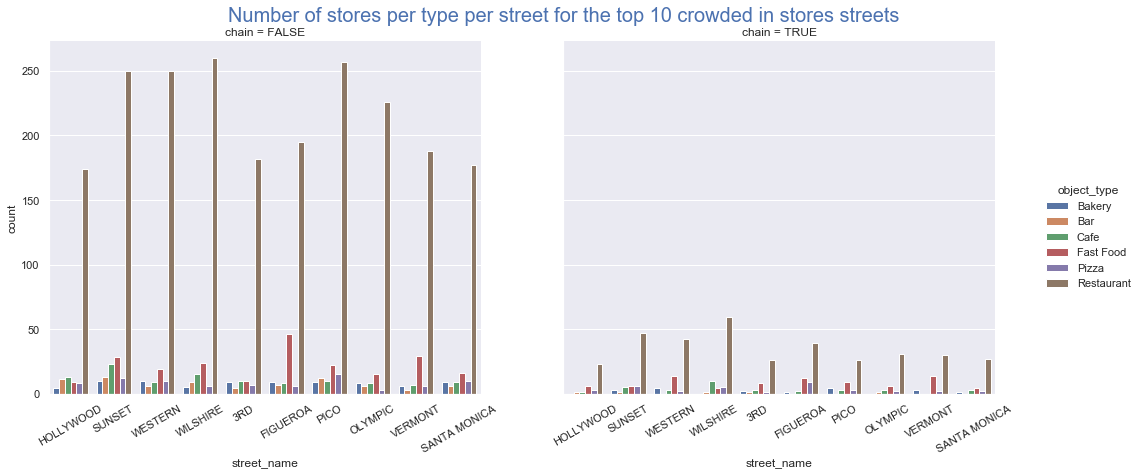

In [87]:
#plot of types
plot_data = df[df['street_name'].isin(top10_in_stores['street_name'])]
title ='Number of stores per type per street for the top 10 crowded in stores streets'

plot_count_categories(plot_data,title)

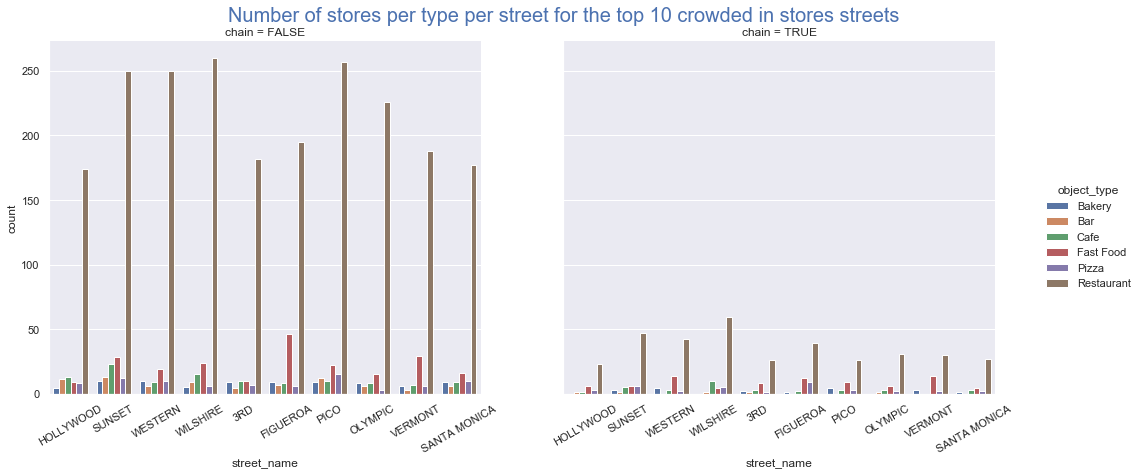

In [88]:
#plot all types besides restaurants
plot_data = df[df['street_name'].isin(top10_in_stores['street_name'])]
title ='Number of stores per type per street for the top 10 crowded in stores streets'

plot_count_categories(plot_data,title)

* Sunset street has the most no-chain cafes while Wilshire has the most chain cafes
* We see no at all chain cafes in Vermont neither chain bars. The fact that there are many fast food establishments maybe indicates Vermont is a central road with noticable flow of people.

### Find the number of streets that only have one restaurant.
<A id="4.7"><a/>

In [89]:
number_establishments=df.groupby('street_name',as_index=False).agg({'object_type':'count'})
only_1_establishment=number_establishments[number_establishments['object_type']==1]
print('{} streets with only 1 establishment'.format(only_1_establishment.shape[0]))

202 streets with only 1 establishment


In [90]:
number_establishments=df[df['object_type']=='Restaurant'].groupby('street_name',as_index=False)\
.agg({'object_type':'count'})
only_1_restaurant=number_establishments[number_establishments['object_type']==1]
print('{} streets with only 1 restaurant'.format(only_1_restaurant.shape[0]))

201 streets with only 1 restaurant


### For streets with a lot of restaurants, look at the distribution of the number of seats. What trends can you see?
<a id="4.8"><a/>

In [91]:
top_streets_general=list(df['street_name'].value_counts()[:10].index)
fig=px.histogram(df[df['street_name'].isin(top_streets_general)],x='number')
fig.show()

* The most frequent size of establishments we meet is from 0 to 49 seats.
* A further inner spike we can observe in this which shows us stores that hold seats between 25-29 with the highest occurrency.

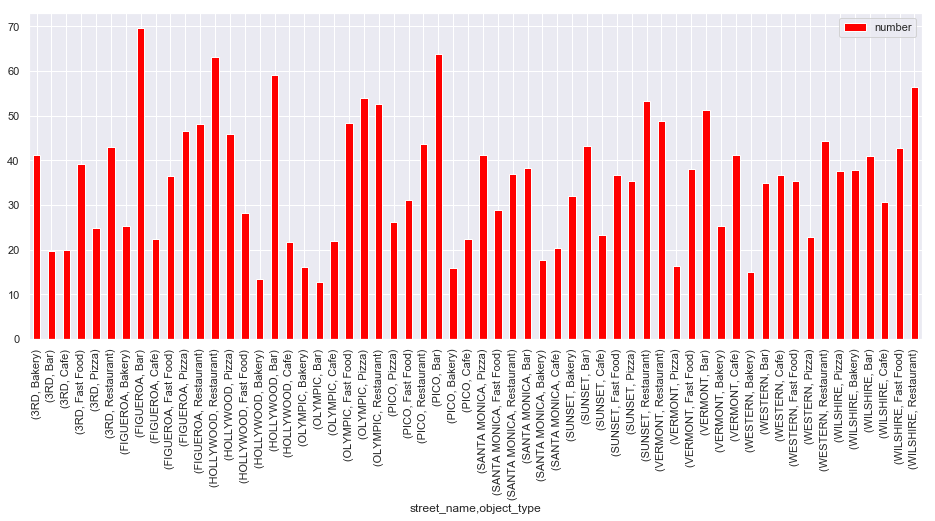

In [92]:
#Mean number of seats per street of the top 10 most popular streets for each type of establishment in each street
df[df['street_name'].isin(top_streets_general)].groupby(['street_name','object_type'])\
                                                        .agg({'number':'mean'})\
.sort_values('street_name').plot(kind='bar',figsize=(16,6),color='red')
plt.show()

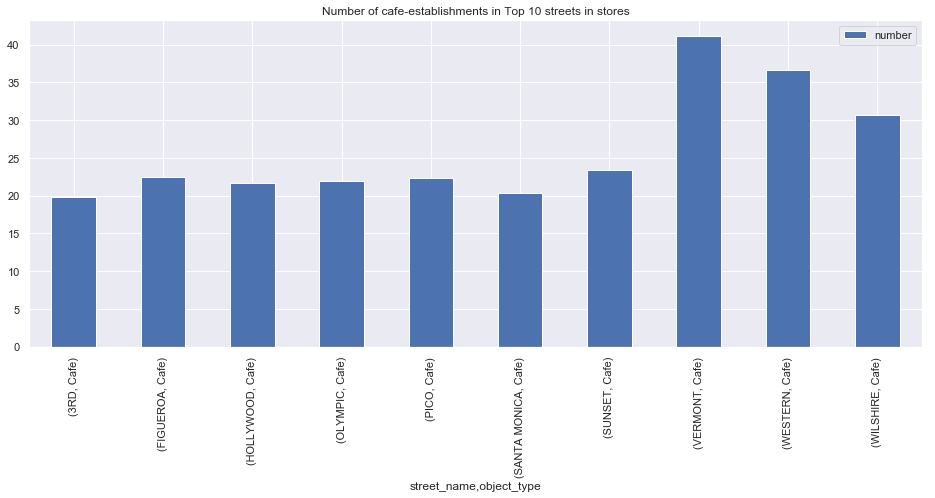

In [93]:
df[(df['street_name'].isin(top_streets_general)) & (df['object_type']=='Cafe')]\
    .groupby(['street_name','object_type'])\
    .agg({'number':'mean'})\
    .sort_values('street_name').plot(kind='bar',figsize=(16,6))
plt.title('Number of cafe-establishments in Top 10 streets in stores')
#plt.savefig(my_path+'/Number_of_cafe-establishments_in_Top_10_streets_in_stores.png',dpi=300,bbox_inches="tight")
plt.show()


* Vermont street which doesn't have any chain cafe has the highest mean number of seats for no-chain cafe.
* Santa monica and 3rd have the lowest mean of seats with the less stores of chain cafes and bars with santa monica having not at all any chain-bar

In [94]:
top20_seat_stores.head()

chain_name  number_of_stores      seats
0  THE COFFEE BEAN & TEA LEAF                33  26.878788
1                      SUBWAY                24  17.458333
2                  YOGURTLAND                11  17.000000
3                    WINGSTOP                10  26.000000
4              DOMINO'S PIZZA                 9  11.111111

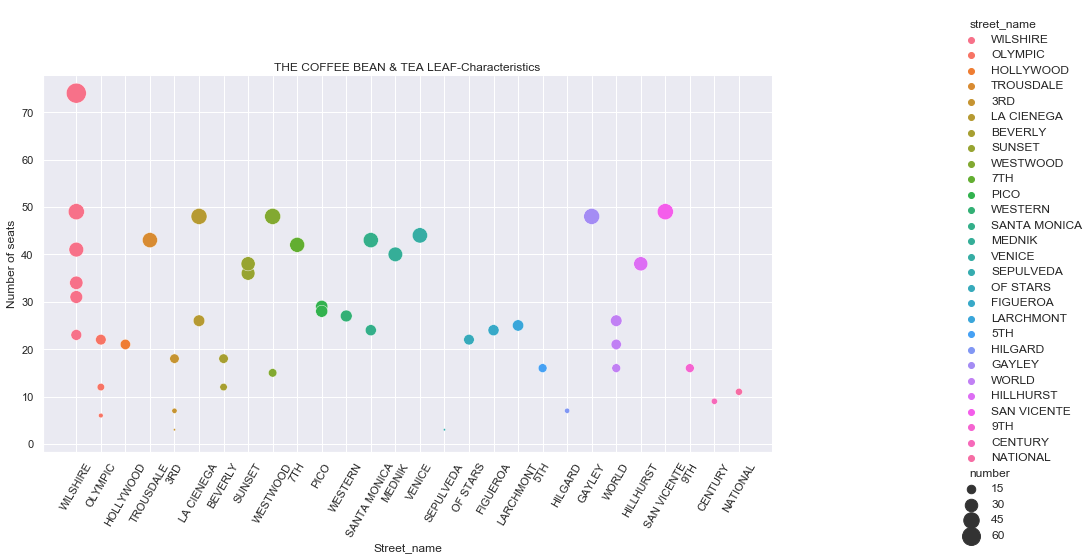

In [95]:
#General pattern for the biggest cafe-chain the THE COFFEE BEAN & TEA LEAF
g=sns.relplot(x='street_name',y='number',hue='street_name',sizes=(0,400),\
              size='number',data=df[df['object_name']=='THE COFFEE BEAN & TEA LEAF'])
g.fig.set_size_inches(16,6)
g.set(xlabel='Street_name',ylabel='Number of seats')
plt.title('THE COFFEE BEAN & TEA LEAF-Characteristics')
plt.xticks(rotation=60)

#plt.savefig(my_path+'/THE_COFFEE_BEAN_&_TEA_LEAF-Characteristics.png',dpi=100,bbox_inches="tight")
plt.show()

In [96]:
df[df['object_name']=='THE COFFEE BEAN & TEA LEAF']['street_name'].unique()

array(['WILSHIRE', 'OLYMPIC', 'HOLLYWOOD', 'TROUSDALE', '3RD',
       'LA CIENEGA', 'BEVERLY', 'SUNSET', 'WESTWOOD', '7TH', 'PICO',
       'WESTERN', 'SANTA MONICA', 'MEDNIK', 'VENICE', 'SEPULVEDA',
       'OF STARS', 'FIGUEROA', 'LARCHMONT', '5TH', 'HILGARD', 'GAYLEY',
       'WORLD', 'HILLHURST', 'SAN VICENTE', '9TH', 'CENTURY', 'NATIONAL'],
      dtype=object)

* The 'THE COFFEE BEAN & TEA LEAF' has only one store in the streets: HOLLYWOOD,TROUSDALE,WESTERN,SEPULVEDA,OF STARS,FIGUEROA,LARCHMONT,5TH,HILGARD,GAYLEY,HILLHURST,SAN VICENTE,9TH,CENTURY and NATIONAL. Which is 15 streets in total with one store out of the 28 streets that can this brand be found.

### Overall conclusion and provide recommendations on a Cafe establishment and number of seats. Comments on the possibility of developing a chain.
<a id="5"><a/>

* WILSHIRE street has the most stores of the biggest chain the  'THE COFFEE BEAN & TEA LEAF', with number of seats ranging 20+ till 75 seats.In only 6 streets this brand has more than one store while in 15 out of 28 streets that can be found has only 1 store.
* Vermont street which doesn't have any chain cafe has the highest mean of seats for no-chain cafe.
* Santa monica and 3rd have the lowest mean of seats with the less stores of chain cafes and bars with santa monica having not at all any chain-bar.
* No-chain cafes tend to have less seats ~20 than chain cafes who have a mean of 25 seats.'THE COFFEE BEAN & TEA LEAF' has a mean number of 26,9 seats.
* Sunset street has the most no-chain cafes and Wilshire has the most chain-cafe. That could mean Wilshire is a more central commercial street.
* We see no at all chain-cafes in Vermont neither chain-bars. The fact that there are many fast food establishments maybe indicates Vermont is a central road with noticable flow of people or the average age of customers could be more young or teenagers.
> Recommendations:
* Depends on the budget of the investment since we are interested in run a robot-cafe chain, may we should look for the Vermont and Santa monica streets, where they don't have many restaurants which may illustrates a younger average of customers age while in Vermont there is not even one chain-cafe. In Santa monica street 'THE COFFEE BEAN & TEA LEAF' has already 2 stores with 25 and 40+ seats. Due to the strategy of our markething we could try to open a small cafe with max 10-14 seats (which is the most frequent number of seats for a cafe) next to or nearby 'THE COFFEE BEAN & TEA LEAF' store at the streets where this brand has only 1 store.
* Additional data like rent cost per sq.m or which streets have the most companies/offices or which streets are nearby a park could help us for further conclusions since people from offices or people they go to the park spend less time to drink a coffee or they just grab a coffee to go,hence a robot cafe fulfils the profile of a cafe for this purposes.

<div class="alert alert-success"> <b>Reviewer comment:</b> 
    
Overall, the work is very good. A fairly large amount of information has been used, which adds up to one general picture.
    
In fact, where we use repetitive actions for plotting graphs, that is, graphs of the same type, I recommend creating functions so as not to write the same code several times. Thus, we will be able to automate and optimize our project.
    
---
    
    
The presentation was done well, especially pleased:
    
- its structure
- availability of general conclusions and recommendations
- conclusions for all charts
- sequence
- style
    
How it could be improved further:
    
- form a summary at the very beginning of the presentation, everyone loves to see the result right away 😊
- add the purpose of the study itself on the second slide
- number slides

    
Otherwise, everything is wonderful😊
    
Congratulations on the successful completion of the project 😊👍
    
And I wish you success in your new work 😊
    
</div>

